# Project strategy of interaction with clients based on analytical data

Project description:

The network of fitness centers "Kulturist-datasaentist" develops a strategy of interaction with clients based on analytical data.


A common problem with fitness clubs and other services is customer churn. How do you know that the client is no longer with you? You can write in the outflow of those who asked to close the contract or deleted the account. However, customers do not always leave defiantly: they often stop using the service quietly.


Indicators of outflow depend on the specifics of the industry. When a user rarely, but consistently buys in an online store — it does not look like he "fell off". But if two weeks does not go to the channel with daily updated content, things are bad: the subscriber is bored and seems to have left you.


For a fitness center, you can assume that the client has fallen into the outflow if he has never visited the gym in the last month. Of course, it is possible that he left for Bali and upon arrival will definitely continue to go to fitness. However, the opposite is more often the case. If a client started a new life on Monday, went to the gym for a while, and then disappeared-most likely, he will not return.


To combat the outflow, the customer service department of the "Data Scientist-Bodybuilder" has converted many customer profiles into electronic form. Your task is to analyze and prepare an action plan for customer retention.

## Импорт библиотек и чтение файла.

In [1]:
pip install jupyter_contrib_nbextensionspip install https://github.com/ipython-contrib/jupyter_contrib_nbextensions/tarball/masterjupyter contrib nbextension install --user

  ERROR: HTTP error 404 while getting https://github.com/ipython-contrib/jupyter_contrib_nbextensions/tarball/masterjupyter
  ERROR: Could not install requirement https://github.com/ipython-contrib/jupyter_contrib_nbextensions/tarball/masterjupyter because of error 404 Client Error: Not Found for url: https://codeload.github.com/ipython-contrib/jupyter_contrib_nbextensions/legacy.tar.gz/masterjupyter
ERROR: Could not install requirement https://github.com/ipython-contrib/jupyter_contrib_nbextensions/tarball/masterjupyter because of HTTP error 404 Client Error: Not Found for url: https://codeload.github.com/ipython-contrib/jupyter_contrib_nbextensions/legacy.tar.gz/masterjupyter for URL https://github.com/ipython-contrib/jupyter_contrib_nbextensions/tarball/masterjupyter
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [3]:
!pip install seaborn==0.11.0

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 283 kB 1.2 MB/s eta 0:00:01
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.11.1
    Uninstalling seaborn-0.11.1:
      Successfully uninstalled seaborn-0.11.1


In [4]:
import warnings
warnings.simplefilter("ignore")

In [5]:
df = pd.read_csv('/datasets/gym_churn.csv')

## EDA

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


Пропусков в данных нет, все данне представлены в числовом виде. В датасете есть временные показатели, но они не указывают на дату, поэтому можно спокойно сфокусироваться в дальнейшем на регрессионном анализе.

In [7]:
df.describe()[1:3]

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521


Смотрим на средние значения в датасете и стандартные отклонения. Предполагаю, что не нужно много внимания обращать на те показатели, которые имеют бинарную структуру. В таком случае, стандартное отклонение от среднего не будет сильно показтельным. Можно решить, что это относится почти ко всем признакам, которые имеют срднее значение меньше 1, если, конечно, они пока не стандартизированы.

Отмечаем, что средний возраст составляет 29 лет, средний контрактный период - 4.5 месяца (но с высоким стандартным отклонением, равным среднему), средняя суммарная выручка от других услуг 147 со средним отклонением 96. Среднее время с момента первого обращения в фитнес-центр в месяцах - 3.7 с эквивалентным стандартным отклонением; средняя частота посещений 1.87 раз со ст. откл. 0.97

In [8]:
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [9]:
grouped_data = df.groupby('Churn').agg(['mean', 'std'])

In [10]:
grouped_data.head()

gender           Near_Location             Partner            \
           mean       std          mean       std      mean       std   
Churn                                                                   
0      0.510037  0.499984      0.873086  0.332933  0.534195  0.498914   
1      0.510839  0.500118      0.768143  0.422217  0.355325  0.478837   

      Promo_friends               Phone            ...  \
               mean       std      mean       std  ...   
Churn                                              ...   
0          0.353522  0.478144  0.903709  0.295040  ...   
1          0.183789  0.387495  0.902922  0.296204  ...   

      Avg_additional_charges_total            Month_to_end_contract            \
                              mean        std                  mean       std   
Churn                                                                           
0                       158.445715  99.801599              5.283089  4.363522   
1                       115.082899  77.696419              1.662582  1.964593   

       Lifetime           Avg_class_frequency_total            \
           mean       std                      mean       std   
Churn                                                           
0      4.711807  3.874780                  2.024876  1.016006   
1      0.990575  1.110799                  1.474995  0.694705   

      Avg_class_frequency_current_month            
                                   mean       std  
Churn                                              
0                              2.027882  1.018994  
1                              1.044546  0.770237  

[2 rows x 26 columns]

Глядя на сравнение двух групп, сразу можно заметить, что гендер на это вряд ли как-то влияет, значения почти идентичные в двух случах. Разница заметна в случае, если человек пришел от знакомого, если у него больше месяцев по контракту, то он скорее останется, то же самое и с длительностью общих посещений - чем дольше клиент, тем скорее он не уйдет.

In [11]:
df_here = df.loc[df['Churn'] == 0]

In [12]:
df_left = df.loc[df['Churn'] == 1]

In [13]:
list_of_columns = list(df.columns[:-1])

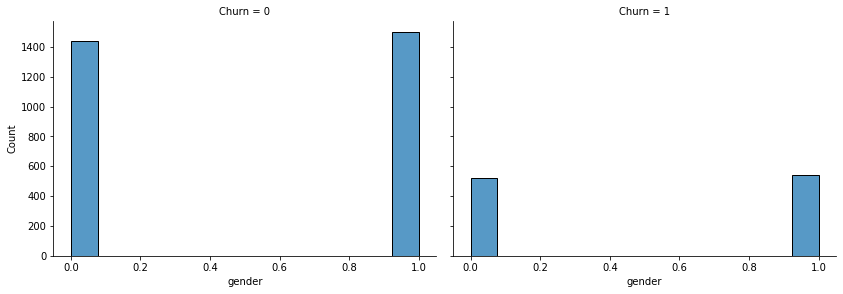

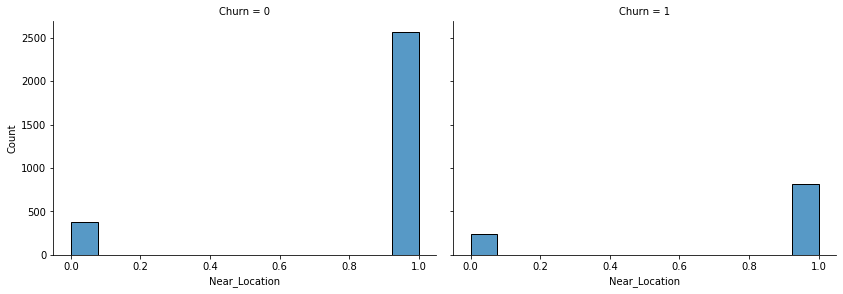

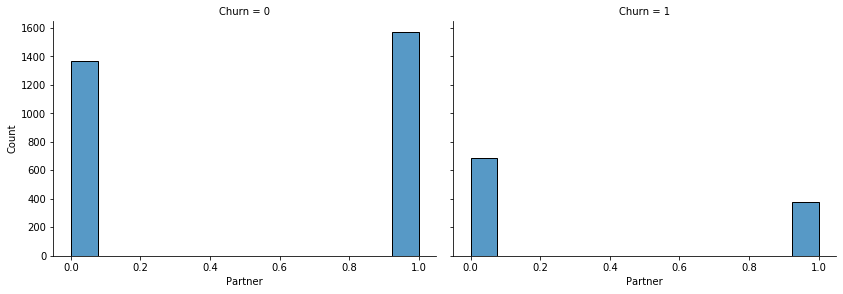

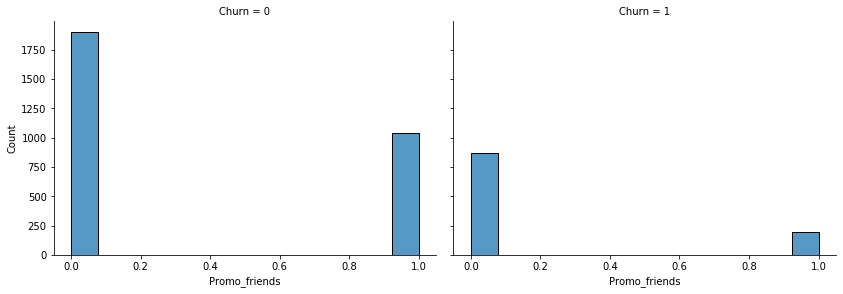

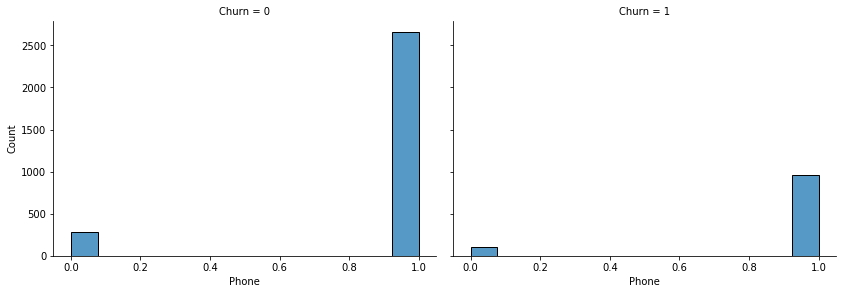

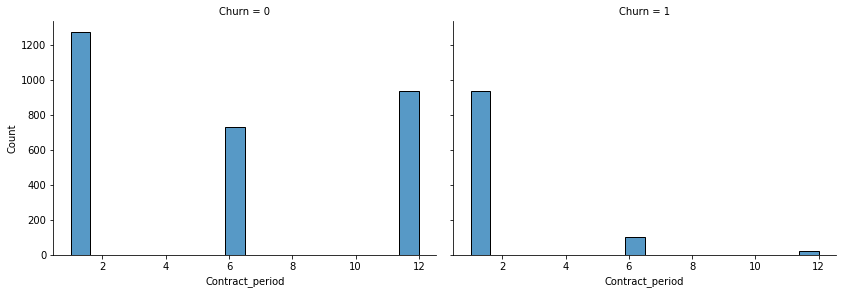

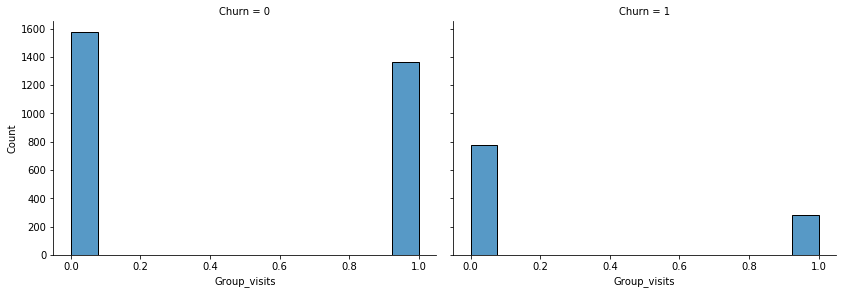

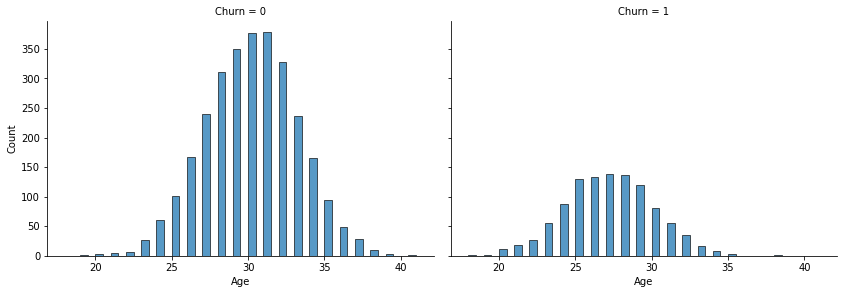

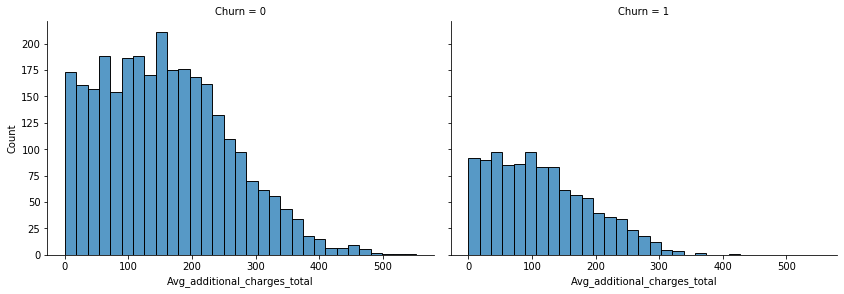

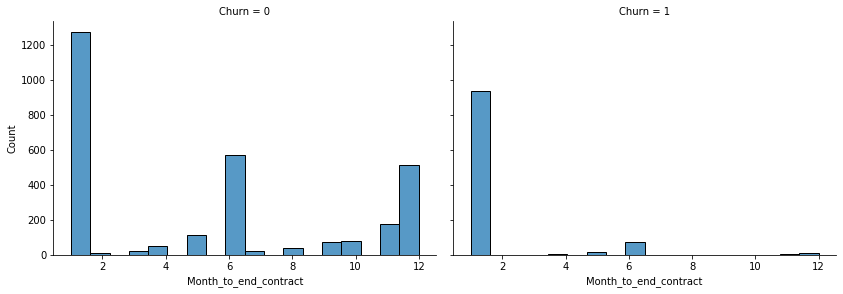

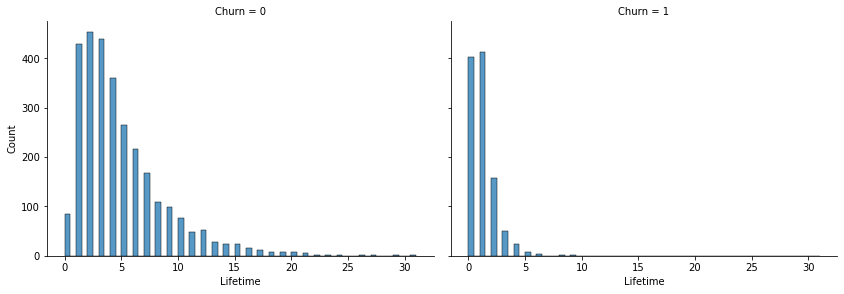

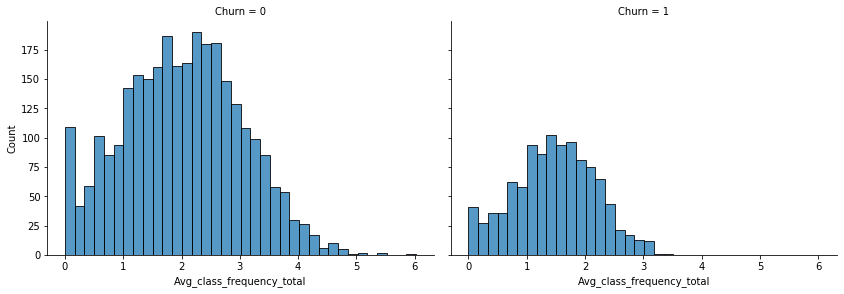

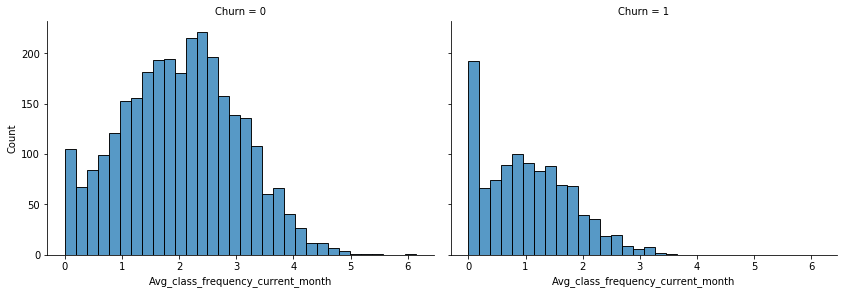

In [14]:
for i in list_of_columns:
    g = sns.displot(df, x=df[i], col = 'Churn', palette='Set2')
    g.fig.set_figwidth(12)
    g.fig.set_figheight(4)
        

Графики распредения в целом нам говорят о следующем. В обеих группах гендеры разделены равномерно. Обе группы также показывают, что большая часть людей ходят в зал рядом с домом. Среди покинувших клуб больше тех, кто не является партнером клуба, а с оставшимися людьми все наоборот, но перевес незначителен.Интересен показатель контрактного периода, среди покинувших клуб этот признак очень невелик, меньше двух месяцев для большинства людей. Это же мы можем заметить и на примере признака оставшихся месяцев, месяцев мало, люди покидают клуб  

In [15]:
cm = df.corr() 

Text(0.5, 1, 'Correlation Heatmap')

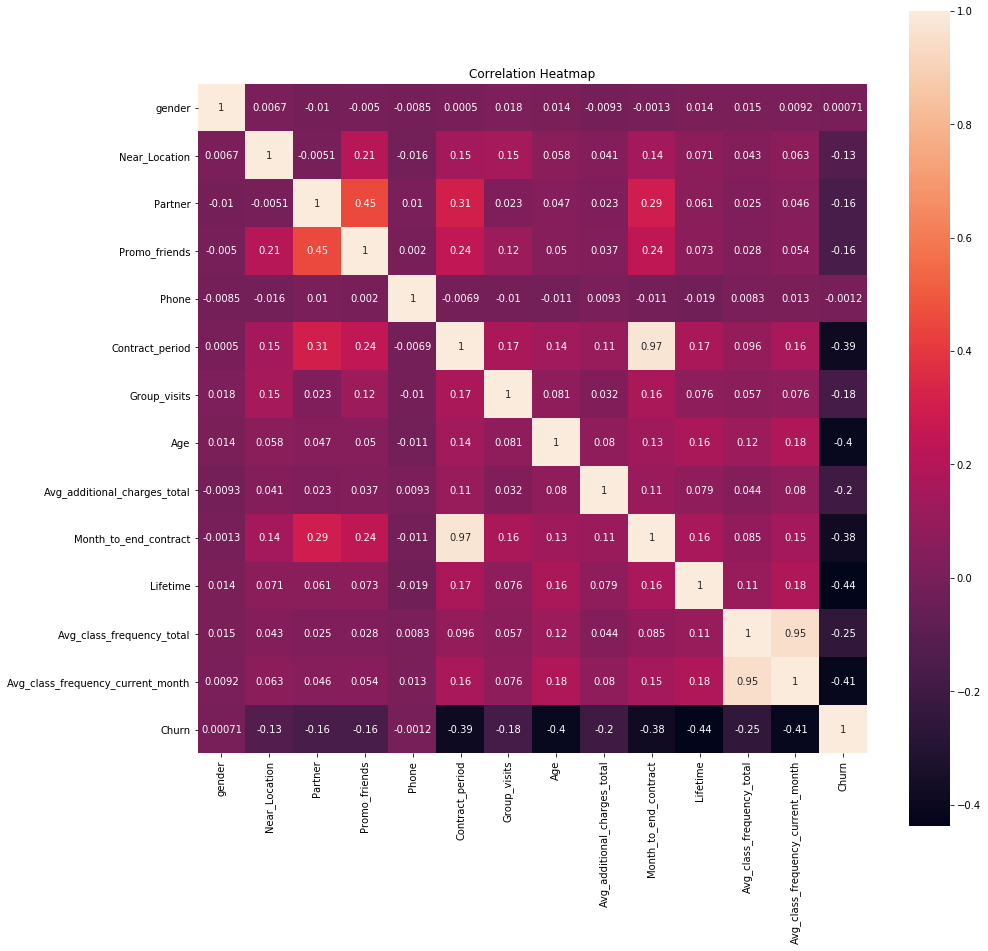

In [16]:
fig, ax = plt.subplots()
fig.set_size_inches(15,15)
sns.heatmap(cm, annot = True, square=True)
plt.title('Correlation Heatmap')

Как и было замечено ранее, высокие показатели отрицательной корреляции показывают два признака - количество месяцев до конца контракта, длительность контрактного периода. Однако, что не было замечено ранее, высокие показатели отрицательной корреляции с фактом продолжения занятий показывают также возраст и количество посещений клуба в месяц.

## Построение модели прогнозирования оттока клиентов

Так как у нас нет дат в данных, то мы можем спокойно разделять наши данные для дальнейшего регрессионого анализа по самому простому способу, 80 на 20. Целевая переменная здесь Churn

In [17]:
X = df.drop(columns=['Churn'])
y = df['Churn']

разделяем модель на обучающую и валидационную выборки

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [19]:
models = [
    LogisticRegression(),
    RandomForestClassifier(),
]

In [20]:
def study(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    probabilities = model.predict_proba(X_test)[:, 1]
    predictions = model.predict(X_test)
    print('Accuracy: {:.2f}'.format(accuracy_score(y_test, predictions)))
    print('Precision: {:.2f}'.format(precision_score (y_test, predictions)))
    print('Recall: {:.2f}'.format((recall_score (y_test, predictions))))

In [21]:
for i in models:
    print(i)
    study(i, X_train, y_train, X_test, y_test)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
Accuracy: 0.93
Precision: 0.86
Recall: 0.83
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Accuracy: 0.89
Precision: 0.80
Recall: 0.73


Доля правильных ответов для модели логической регрессии - 93%, для случайного леса - 90%
Точность (доля правильных ответов только среди целевого класса) для модели логической регрессии - 86%, для случайного леса - 83%
Полнота (сколько реальных объектов класса вы смогли обнаружить с помощью модели) для модели логической регрессии - 83%, для случайного леса - 76% (тут цифры каждый раз чуть разные, менять значения не стану, так как по несколько раз перезапускаю проект)

На основании этих метрик логистическая регрессия показала себя лучше, она более точная и полная, в сравнении с случайным лесом.

## Кластеризация клиентов.

Стандартизиурем данные и построим дендограмму по кластерам.

In [22]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)

linked = linkage(X_sc, method = 'ward') 

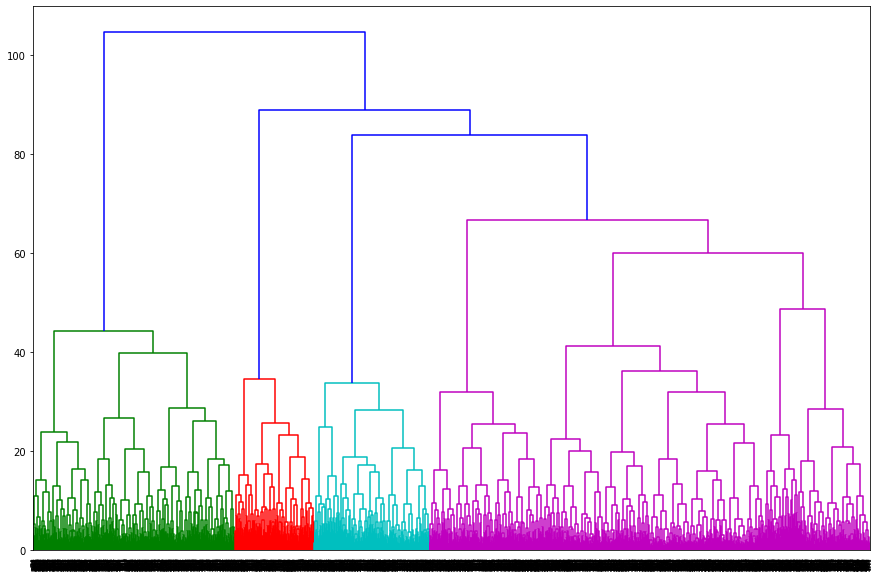

In [23]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show() 

Разных цветов - 5, а значит и кластеров будет столько же

Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов

In [24]:
km = KMeans(n_clusters = 5) # задаём число кластеров, равное 5
labels = km.fit_predict(X_sc) # применяем алгоритм к данным и формируем вектор кластеров

In [25]:
('Silhouette_score: {:.3f}'.format(silhouette_score(X_sc, labels)))

'Silhouette_score: 0.141'

Метрика силуэта показывает, насколько объект своего кластера похож на свой кластер больше, чем на чужой. Показатель 0.141 не очень близок к 1, на графике предыдущем это заметно, кластеров может быть больше, так как четко отделяемых групп внизу не особо видно

In [26]:
df['cluster'] = labels

In [27]:
grouped_data_2 = df.groupby('cluster').agg(['mean', 'std'])

In [28]:
grouped_data_2

gender           Near_Location             Partner            \
             mean       std          mean       std      mean       std   
cluster                                                                   
0        0.500988  0.500246      0.960474  0.194938  0.782609  0.412675   
1        0.486246  0.500013      1.000000  0.000000  0.350324  0.477264   
2        0.497041  0.500485      0.000000  0.000000  0.461538  0.499011   
3        0.523316  0.500104      0.862694  0.344616  0.471503  0.499835   
4        0.557625  0.496958      0.977881  0.147155  0.356228  0.479163   

        Promo_friends           Phone       ... Month_to_end_contract  \
                 mean       std  mean  std  ...                  mean   
cluster                                     ...                         
0            0.573123  0.494869     1  0.0  ...              9.956522   
1            0.237055  0.425448     1  0.0  ...              1.873786   
2            0.078895  0.269842     1  0.0  ...              2.224852   
3            0.305699  0.461301     0  0.0  ...              4.466321   
4            0.236321  0.425069     1  0.0  ...              2.383003   

                   Lifetime           Avg_class_frequency_total            \
              std      mean       std                      mean       std   
cluster                                                                     
0        2.560077  4.727273  3.901701                  1.994163  0.934238   
1        1.888450  2.360841  2.767519                  1.233348  0.623808   
2        2.455279  2.812623  3.144479                  1.662253  0.843851   
3        4.253055  3.940415  4.052778                  1.854211  0.936601   
4        2.212750  4.947614  4.180742                  2.811502  0.699140   

        Avg_class_frequency_current_month               Churn            
                                     mean       std      mean       std  
cluster                                                                  
0                                1.987259  0.940170  0.027668  0.164101  
1                                0.995384  0.634235  0.521036  0.499760  
2                                1.480228  0.937916  0.441815  0.497093  
3                                1.723967  1.022920  0.266839  0.442882  
4                                2.806612  0.715401  0.072177  0.258931  

[5 rows x 28 columns]

Смотрим на распредление по кластерам и на показатель оттока: самые высокие показтели в 3 и 4 кластерах (нумерация с 0). Самый низкий показатель оттока у 1 кластера. Показатели 0 и 2 кластеров примерно равны и средние.

In [29]:
list_of_columns = list(df.columns[:-2])

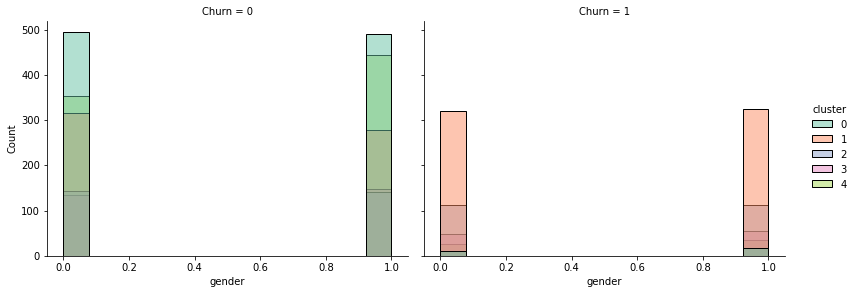

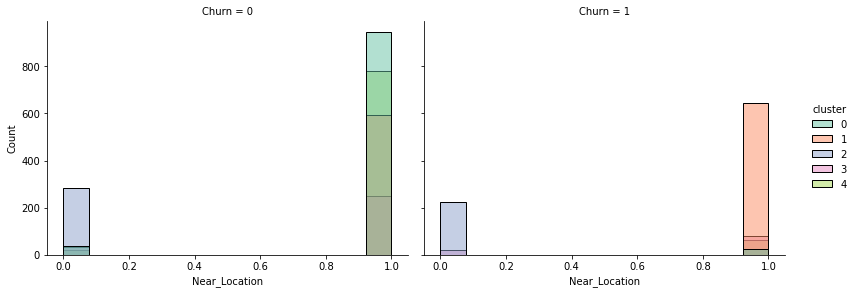

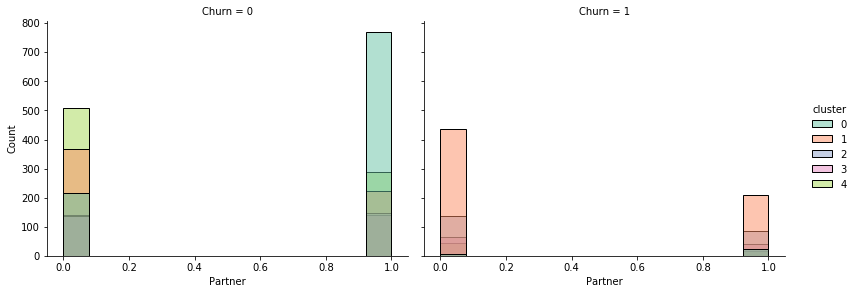

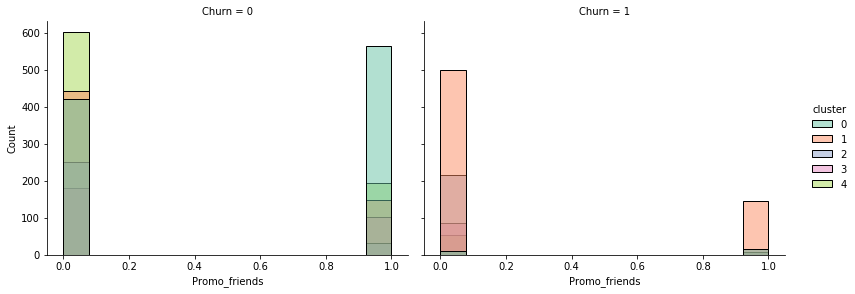

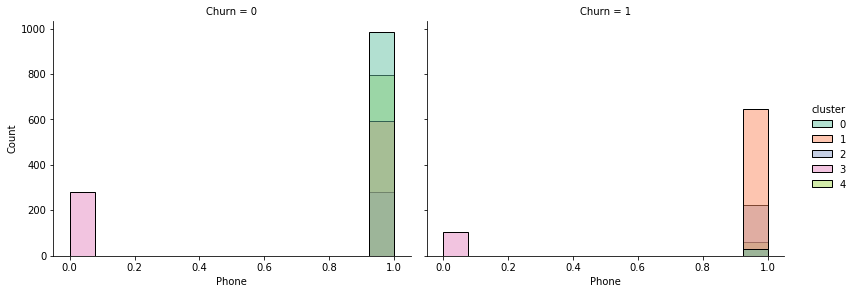

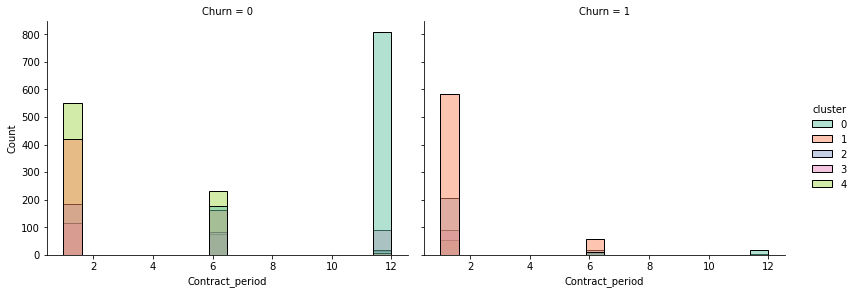

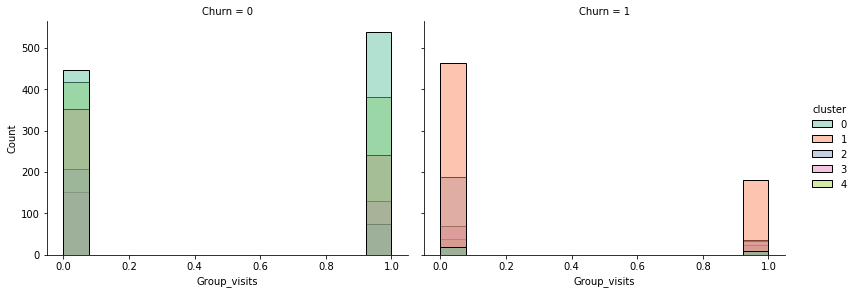

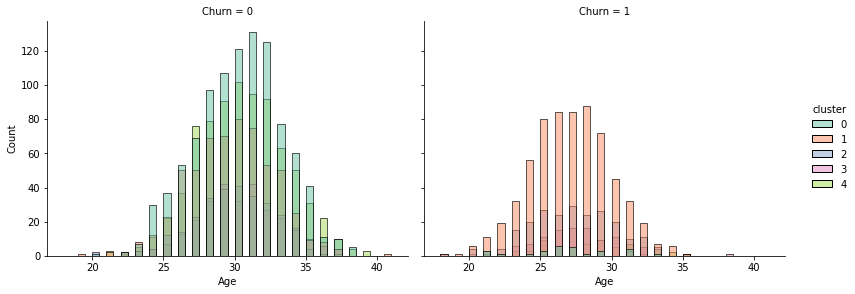

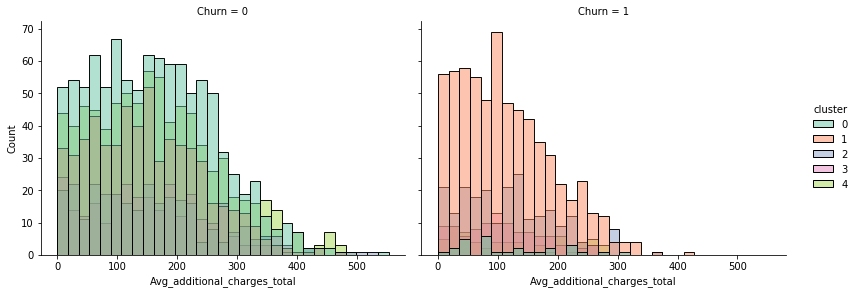

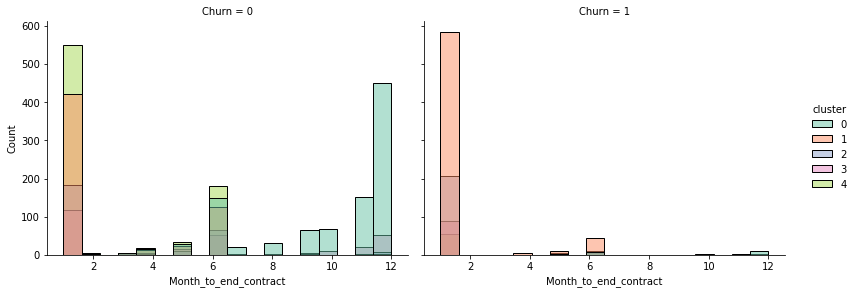

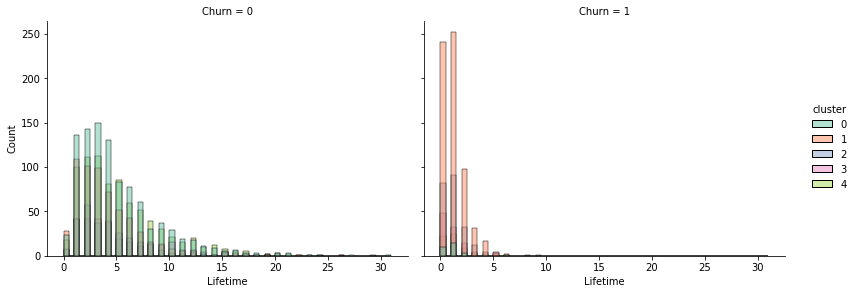

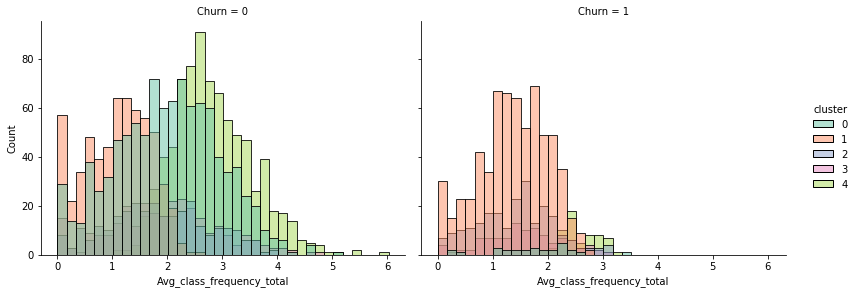

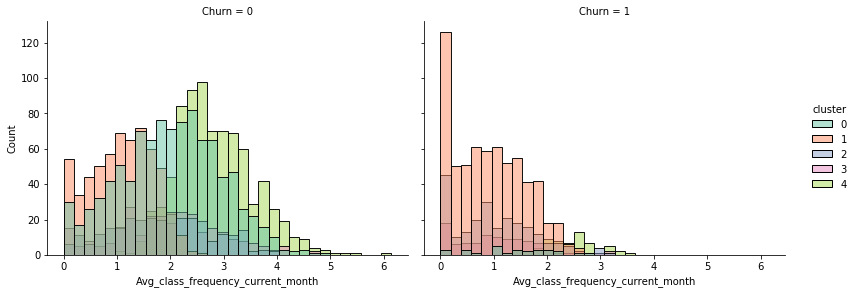

In [30]:
for i in list_of_columns:
    g = sns.displot(df, x=df[i], col = 'Churn', hue="cluster", palette='Set2')
    g.fig.set_figwidth(12)
    g.fig.set_figheight(4)

Посмотрим на графики


У нас уже были выделены некоторые основные направления, куда надо смотреть:
1. близость к дому показывает, что это важный признак для кластера номер 3, чтобы покинуть клуб (хотя звучит абсурдно). А вот то, что 4 кластер охотно бросает все, если клуб не рядом, вот это уже кажется неплохим исследованием.
2. также для 3 кластера характерна привычка бросать все, если ты не партнер клуба и если пришел не от друга, а вот для 1 кластера это наоборот играет роль
3. Если указали номер, то чаще всего опять же бросают занятия люди из 3го кластера.

И так далее, на самом деле, 3 кластер показывает основные характеристики человека, который скорее всего бросит заниматься.

In [31]:
part_of_churn = df.groupby(['cluster']).agg({'Churn':'mean'}).T

In [32]:
display(part_of_churn)

cluster,0,1,2,3,4
Churn,0.027668,0.521036,0.441815,0.266839,0.072177


Итак, доля оттока

для 0 кластера = 2.2%

для 1 = 25%

для 2 = 6.3%

для 3 = 52%

для 4 = 45%

Как и было замечено ранее, самый опасный кластер - 3, за ним 4

## Conclusion

Knowing that the main threat to leave the institution is people from the 3 cluster, we will describe their characteristics:
1. Gender is not so fundamental
2. All people in the 3rd cluster are characterized by a close place of residence near the club. (same for the best cluster)
3. Not participating in the partner program (74% for the best cluster)
4. Do not participate in the program by invitation from friends (49 for the best cluster)
5. Specify the phone number
6. 2 months until the end of the purchased club card (10.9 for the best cluster)
7. 2.5 months of trips to the gym, no more (4.69 for the best cluster)
8. 1.29 visits per week (1.99 for the best cluster)
9. 1 visit per week on average for the previous month (1.98 for the best cluster)

Based on this, it seems logical to actively promote various partner programs and develop a strategy to attract new customers through friends. This is exactly the competence of the interested club. Everything else is quite subjective due to the fact that the client may like the hall, or not because of certain factors, for example, the lack of a swimming pool.